# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


In [1]:
import numpy as np
import os
from skimage.transform import resize
import skimage.io
import pandas as pd

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["imagenum"],axis=1)
    
    return all_photos, all_attrs

# Vanilla Autoencoder (2 балла)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
PATH = '/content/gdrive/MyDrive/models/'

## Prepare the data


In [4]:
import numpy as np

from PIL import Image
from skimage.io import imread

from torch.autograd import Variable
from torchvision import transforms
from IPython.display import clear_output
from time import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt


%matplotlib inline

In [129]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

In [130]:
attrs

,person,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace,photo_path
0,Aaron Eckhart,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609,lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0...
1,Aaron Guiel,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559,lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
2,Aaron Patterson,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231,lfw-deepfunneled/Aaron_Patterson/Aaron_Patters...
3,Aaron Peirsol,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025,lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0...
4,Aaron Peirsol,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127

In [7]:
# Для удобства создаем кастомный датасет
class lfwDataset(data_utils.Dataset):
  def __init__(self, data, person):
    super().__init__() 
    self.data = data
    self.length = len(self.data)
    self.person = person

  def __len__(self):
    return self.length

  def __getitem__(self, index):
    transform = transforms.Compose([
            transforms.ToTensor()
        ])
    
    x = self.data[index]
    p = self.person[index]
    x = transform(x)
    return (x, p)

In [8]:
# Определяем функцию для отображения картинок из тензоров
def imshow(inp, plt_ax=plt, title=''):
    """Imshow для тензоров"""
    if len(inp.size()) == 4:
      inp = inp.squeeze(0)

    inp = inp.numpy().transpose((1, 2, 0))
    plt_ax.imshow(inp)
    plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{DEVICE}: {torch.cuda.get_device_name()}')

cuda: Tesla K80



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [14]:
def split_data_idx(data, train_part=0.8):
  indices = np.random.permutation(data.shape[0])
  edge = int(data.shape[0] * train_part)
  return indices[:edge], indices[edge:]

In [15]:
training_idx, validation_idx = split_data_idx(data)

train_imgs = lfwDataset(data[training_idx], 
                        attrs['person'].iloc[training_idx].to_numpy())
val_imgs = lfwDataset(data[validation_idx], 
                      attrs['person'].iloc[validation_idx].to_numpy())

In [16]:
batch_size = 25

data_tr = data_utils.DataLoader(train_imgs, 
                     batch_size=batch_size, shuffle=True)
data_val = data_utils.DataLoader(val_imgs, 
                     batch_size=batch_size, shuffle=True)

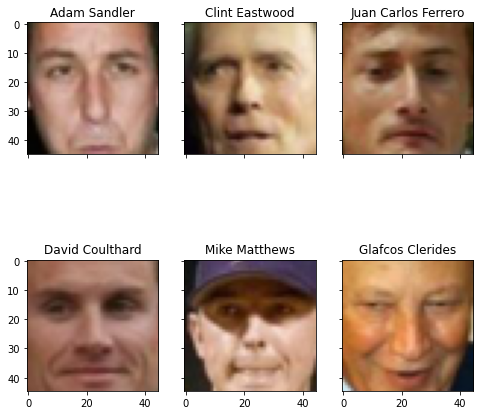

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_imgs)))
    im_val, person, = val_imgs[random_characters]
    imshow(im_val,plt_ax=fig_x, title=person)

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

In [ ]:
dim_code = 20 # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class CEncoder(nn.Module):
  def __init__(self, dim_code):
    super().__init__()
    self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2, 2)

    self.enc_conv2 = nn.Conv2d(32, 64,kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2, 2)

    self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2, 2)

    self.in_h = nn.Linear(128*5*5, dim_code)

  def forward(self, x):
    x = self.enc_conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.pool1(x)

    x = self.enc_conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.enc_conv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.pool3(x)

    x = torch.flatten(x, start_dim=1)
    x = self.in_h(x)
    x = F.relu(x)
    latent_code = x

    return latent_code

class CDecoder(nn.Module):
  def __init__(self, dim_code):
    super().__init__()

    self.out_h = nn.Linear(dim_code, 128*5*5)
    self.bn1 = nn.BatchNorm2d(64)
    self.dec_upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.dec_upsample2 = nn.ConvTranspose2d(64, 32,kernel_size=3, stride=2, 
                                            padding=1, output_padding=1)
    self.dec_upsample3 = nn.ConvTranspose2d(32, 3,kernel_size=3, stride=2)

  def forward(self, x):
    x = self.out_h(x)
    x = F.relu(x)
    x = x.view(-1, 128, 5, 5)

    x = self.dec_upsample1(x)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.dec_upsample2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.dec_upsample3(x)
    x = torch.sigmoid(x)
    reconstruction = x

    return reconstruction

class Autoencoder(nn.Module):
    def __init__(self, dim_code):
      super().__init__()

      self.encoder = CEncoder(dim_code)
      self.decoder = CDecoder(dim_code)
      
    def forward(self, x):

      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)

      return reconstruction, latent_code

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
# Обучим одну эпоху
def train_epoche_ae(model, opt, loss_fn, data_tr):
  avg_loss = 0
  model.train()
  for (X_batch, _) in data_tr:
    # поместим данные на device
    X_batch = X_batch.to(DEVICE, dtype=torch.float)

    # занулим градиенты
    opt.zero_grad()

    # forward
    rec, code = model(X_batch)
    loss = loss_fn(rec, X_batch) # forward-pass
              
    loss.backward()  # backward-pass
    opt.step()  # обновим веса 

    avg_loss += loss / len(data_tr) # вычислим средний лосс по эпохе

  return avg_loss

def ae_train(model, opt, loss_fn, data_tr, data_val, epochs):
  X_val, _ = next(iter(data_val))
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    print(f'* Epoch {epoch+1}/{epochs}')

    tic = time()
    avg_loss = train_epoche_ae(model, opt, loss_fn, data_tr)
    toc = time()
    train_losses.append(avg_loss.detach().cpu().numpy())
    t = toc - tic

    # Посчитаем лосс на валидации (для одного батча)
    model.eval()
    rec_val, code_val = model(X_val.detach().to(DEVICE, dtype=torch.float))

    code_val = code_val.detach().cpu()
    rec_val = rec_val.detach().cpu()
    
    val_losses.append(loss_fn(rec_val, X_val))

    torch.cuda.empty_cache()

    # Визуалируем процесс обучения
    clear_output(wait=True)
    for k in range(5):
      plt.subplot(2, 5, k+1)
      plt.imshow(np.rollaxis(X_val[k].numpy().squeeze(), 0, 3))
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 5, k+6)
      plt.imshow(np.rollaxis(rec_val[k].numpy(), 0, 3))
      plt.title('Output')
      plt.axis('off')
    plt.suptitle('%d / %d - loss: %f, time: %f' % (epoch+1, epochs, avg_loss, t))
    plt.show()

  return train_losses, val_losses

In [ ]:
# Загрузим модель с google drive
autoencoder = Autoencoder(20).to(DEVICE)
PATH_ = PATH + 'autoencoder_dim20.model'
autoencoder.load_state_dict(torch.load(PATH_))

<All keys matched successfully>

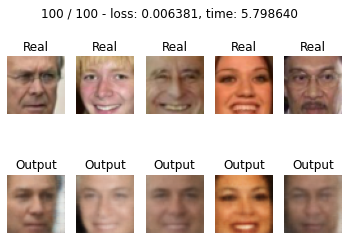

In [ ]:
epochs = 100
criterion = nn.MSELoss()
autoencoder = Autoencoder(dim_code).to(DEVICE)
optimizer = optim.AdamW(autoencoder.parameters(), lr=1e-3)

train_loss, val_loss = ae_train(autoencoder, optimizer, criterion, data_tr, data_val, epochs)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [46]:
# Визуализируем графики изменения лосса 
# на тренировочной части и на валидационной
def history_plot(train_loss, val_loss, epochs):
  plt.plot(range(epochs), train_loss, label='train')
  plt.plot(range(epochs), val_loss, label='val')
  plt.legend()
  plt.xlabel('fit epoch')
  plt.ylabel('loss')
  plt.title('Train/val data loss')
  plt.show()

history_plot(train_loss, val_loss, epochs)

In [ ]:
# Сохраним модель на google drive
PATH_ = PATH + 'autoencoder_dim20.model'
torch.save(autoencoder.state_dict(), PATH_)

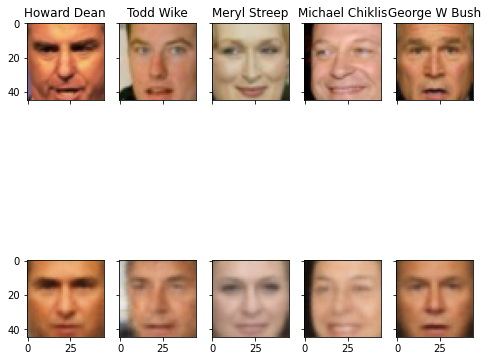

In [ ]:
mean, std = 0, 0
num = 5
# Проверим, как модель востанавливает лица из валидационной выборки.
# Паралельно с этим, посчитаем основные статистики для этих картинок.
# Они будут нужны нам позже 
fig, ax = plt.subplots(nrows=2, ncols=num,figsize=(8, 8), \
                        sharey=True, sharex=True)

for i in range(num):
  random_characters = int(np.random.uniform(0,1000))

  im_val, person = val_imgs[random_characters]
  imshow(im_val, plt_ax=ax[0,i], title=person)

  im_val = im_val.unsqueeze(0).to(DEVICE, dtype=torch.float)
  rec, lc = autoencoder(im_val)
  mean += lc.mean()
  std += lc.std()
  imshow(rec.detach().cpu(), plt_ax=ax[1,i])


mean /= num
std /= num
mean = mean.cpu().detach().numpy()
std = std.cpu().detach().numpy()

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [ ]:
# Визуализируем содержимое батча
def batchshow(imgs, nrows, ncols):

  fig = plt.figure(figsize=(8, 8))

  for i in range(nrows*ncols):
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    imshow(imgs[i,:,:,:] , plt_ax=ax)

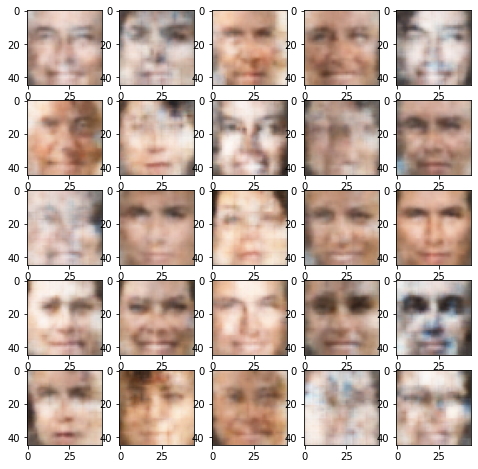

In [ ]:
# Сгенерируем 25 рандомных векторов размера latent_space
coef = 0.8

esp = np.random.randn(25, dim_code)
z = mean + esp * std * coef
z = transforms.ToTensor()(z)
z = z.to(DEVICE, dtype=torch.float)
output = autoencoder.decoder(z)

batchshow(output.detach().cpu(), 5, 5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Получим список всех признаков
print(attrs.columns)

Index(['person', 'Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny 

In [ ]:
# Данная функция будет извлекать код признака из двух наборов данных
def get_attr_code(model, data1, data2):
  code1 = model.encoder(data1).to(DEVICE)
  code2 = model.encoder(data2).to(DEVICE)

  return code1, code2, code1.mean(0) - code2.mean(0)  

In [ ]:
smile_index = attrs[attrs['Smiling'] > 1.8]['Smiling'][:20].index
sad_index = attrs[attrs['Smiling'] < -1]['Smiling'][:20].index

In [ ]:
data_smiles = torch.tensor(np.rollaxis(data[smile_index], 3, 1), 
                           device=DEVICE,
                           dtype=torch.float32)
data_sad = torch.tensor(np.rollaxis(data[sad_index], 3, 1),
                        device=DEVICE,
                        dtype=torch.float32)

In [ ]:
_, sad_code, smile_vector = get_attr_code(autoencoder, data_smiles, data_sad)

# Получаем тот самый вектор улыбки
print(smile_vector.detach().cpu())

tensor([-12.7721,   0.0000,  -2.3677,   0.0000, -10.1400,   2.4774,   3.7068,
         -4.7844, -12.9671,  -5.1576,   2.7595,   0.0000,   0.0000,   6.1168,
          0.0000,  -1.2358,   0.1280,  -6.7167,   0.0000,   0.0000])


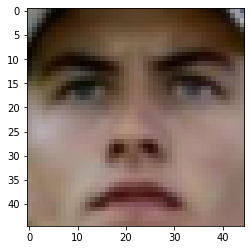

In [ ]:
fig, ax = plt.subplots()
imshow(data_sad[14].detach().cpu(), plt_ax=ax)

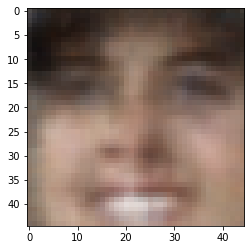

In [ ]:
add_smile = sad_code[14,:] + smile_vector
new_img = autoencoder.decoder(add_smile.to(DEVICE, dtype=torch.float32)).detach().cpu()

# Улыбаемся)
fig, ax = plt.subplots()
imshow(new_img, plt_ax=ax)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [18]:
#Определяем модель с линейными слоями
class VAE(nn.Module):
    def __init__(self, dim_code=2):
      super().__init__()

      self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.2)
      )

      self.in_mu = nn.Linear(128, dim_code)
      self.in_logsigma = nn.Linear(128, dim_code)

      self.decoder = nn.Sequential(
        nn.Linear(dim_code, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.2),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.2),
        nn.Linear(256, 28*28),
        nn.Sigmoid(),
        nn.Unflatten(1, (1, 28, 28))
      )

    def encode(self, x):
      x = self.encoder(x)

      mu = self.in_mu(x)
      logsigma = self.in_logsigma(x)
      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            esp = torch.randn(mu.size(), device=mu.device)
            z = mu + esp * torch.exp(logsigma*0.5)
            return z
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [19]:
# Определяем сверточную модель для lfw датасета. Данная модель используется далее
# для поиска похожих изображеий в датасете 
class ConvVAE(nn.Module):
    def __init__(self, dim_code, ch=3, n_feature_map=(32, 64, 128)):
      super().__init__()

      self.extractor_encoder = nn.Sequential(
        nn.Conv2d(ch, n_feature_map[0], kernel_size=3, padding=1),
        nn.BatchNorm2d(n_feature_map[0]),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(n_feature_map[0], n_feature_map[1],kernel_size=3, padding=1),
        nn.BatchNorm2d(n_feature_map[1]),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(n_feature_map[1], n_feature_map[2], kernel_size=3, padding=1),
        nn.BatchNorm2d(n_feature_map[2]),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten()
      )

      self.in_mu = nn.Linear(n_feature_map[2]*5*5, dim_code)
      self.in_logsigma = nn.Linear(n_feature_map[2]*5*5, dim_code)
      self.out_h = nn.Linear(dim_code, n_feature_map[2]*5*5)

      self.decoder = nn.Sequential(
          nn.Unflatten(1, (n_feature_map[2], 5, 5)),

          nn.ConvTranspose2d(n_feature_map[2], n_feature_map[1], 
                             kernel_size=3, 
                             stride=2),
          nn.BatchNorm2d(n_feature_map[1]),
          nn.ReLU(),
          nn.ConvTranspose2d(n_feature_map[1], n_feature_map[0], 
                             kernel_size=3, 
                             stride=2, 
                             padding=1, 
                             output_padding=1),
          nn.BatchNorm2d(n_feature_map[0]),
          nn.ReLU(),
          nn.ConvTranspose2d(n_feature_map[0], ch, 
                             kernel_size=3, 
                             stride=2)
      )

    def encode(self, x):
      x = self.extractor_encoder(x)
      mu = self.in_mu(x)
      logsigma = self.in_logsigma(x)

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            esp = torch.randn(mu.size(), device=mu.device)
            z = mu + esp * torch.exp(logsigma*0.5)
            return z
        else:
            return mu
    
    def decode(self, z):
        z = self.out_h(z)
        z = F.relu(z)
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [20]:
from torchsummary import summary

cvae = ConvVAE(20).to(DEVICE)
summary(cvae, (3, 45, 45))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 45, 45]             896
       BatchNorm2d-2           [-1, 32, 45, 45]              64
              ReLU-3           [-1, 32, 45, 45]               0
         MaxPool2d-4           [-1, 32, 22, 22]               0
            Conv2d-5           [-1, 64, 22, 22]          18,496
       BatchNorm2d-6           [-1, 64, 22, 22]             128
              ReLU-7           [-1, 64, 22, 22]               0
         MaxPool2d-8           [-1, 64, 11, 11]               0
            Conv2d-9          [-1, 128, 11, 11]          73,856
      BatchNorm2d-10          [-1, 128, 11, 11]             256
             ReLU-11          [-1, 128, 11, 11]               0
        MaxPool2d-12            [-1, 128, 5, 5]               0
          Flatten-13                 [-1, 3200]               0
           Linear-14                   

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [21]:
def loss_fn(x, mu, logvar, recon_x):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

И обучим модель:

In [22]:
from torchvision import datasets

mnist_dataset_tr = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
mnist_dataset_val = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

data_loader_tr = data_utils.DataLoader(mnist_dataset_tr, batch_size=256, shuffle=True)
data_loader_val = data_utils.DataLoader(mnist_dataset_val, batch_size=256, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [43]:
def train_epoche_vae(model, opt, loss_fn, data_tr):
  avg_loss = 0
  model.train()
  for X_batch, _ in data_tr:
    # data to device
    X_batch = X_batch.to(DEVICE, dtype=torch.float)

    # set parameter gradients to zero
    opt.zero_grad()

    # forward
    mu, logsigma, rec = model(X_batch)
    loss = loss_fn(X_batch, mu, logsigma, rec) # forward-pass
              
    loss.backward()  # backward-pass
    opt.step()  # update weights 

    avg_loss += loss / len(data_tr)

  return avg_loss

def vae_train(model, opt, loss_fn, data_tr, data_val, epochs):
  X_val, _ = next(iter(data_val))
  X_val = X_val.float()
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    print(f'* Epoch {epoch+1}/{epochs}')

    tic = time()
    avg_loss = train_epoche_vae(model, opt, loss_fn, data_tr)
    toc = time()
    train_losses.append(avg_loss.detach().cpu().numpy())
    t = toc - tic

    model.eval()
    mu_val, logsigma_val, rec_val = model(X_val.detach().to(DEVICE))

    mu_val = mu_val.detach().cpu()
    logsigma_val = logsigma_val.detach().cpu()
    rec_val = rec_val.detach().cpu()

    val_losses.append(loss_fn(X_val, mu_val, logsigma_val, rec_val))

    torch.cuda.empty_cache()

    # Visualize
    clear_output(wait=True)
    for k in range(5):
      plt.subplot(2, 5, k+1)
      plt.imshow(X_val[k].numpy().squeeze(0), cmap='Greys')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 5, k+6)
      plt.imshow(rec_val[k].numpy().squeeze(0), cmap='Greys')
      plt.title('Output')
      plt.axis('off')
    plt.suptitle('%d / %d - loss: %f, time: %f' % (epoch+1, epochs, avg_loss, t))
    plt.show()

  return train_losses, val_losses

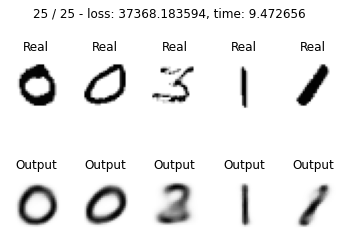

In [44]:
vae20_path = PATH + 'Vae20.model'
epochs = 25
criterion = loss_fn
vae = VAE().to(DEVICE)
optimizer = optim.AdamW(vae.parameters(), lr=1e-2)

train_losses, val_losses = vae_train(vae, optimizer, criterion, data_loader_tr, data_loader_val, epochs)
#torch.save(vae.state_dict(), conv_vae20_path)

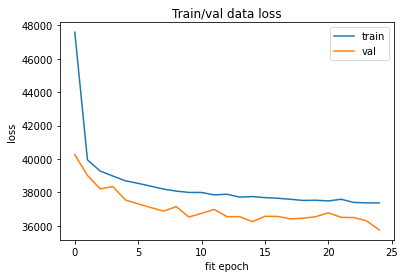

In [47]:
# Визуализируем процесс обучения
history_plot(train_losses, val_losses, epochs)

In [48]:
# Обучаем на 1000 эпохах модель сверточного вариационного автоэнкодера
epochs = 1000
criterion = loss_fn
cvae = ConvVAE(20).to(DEVICE)
optimizer = optim.AdamW(cvae.parameters(), lr=1e-3)

train_losses, val_losses = vae_train(cvae, optimizer, criterion, data_tr, data_val, epochs)

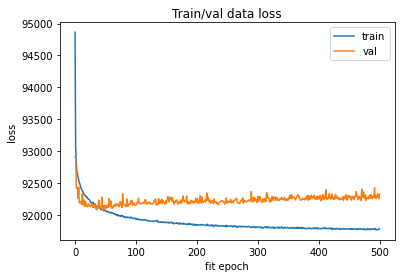

In [ ]:
history_plot(train_losses, val_losses, epochs)

In [ ]:
cvae = ConvVAE(20).to(DEVICE)

conv_vae20_path = PATH + 'CONVvae20.model'

#torch.save(cvae.state_dict(), conv_vae20_path)

cvae.load_state_dict(torch.load(conv_vae20_path))

<All keys matched successfully>

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [49]:
vae = vae.cpu()
z_ = np.random.randn(25, 2)
z_ = torch.tensor(z_, dtype=torch.float)
output = vae.decoder(z_)

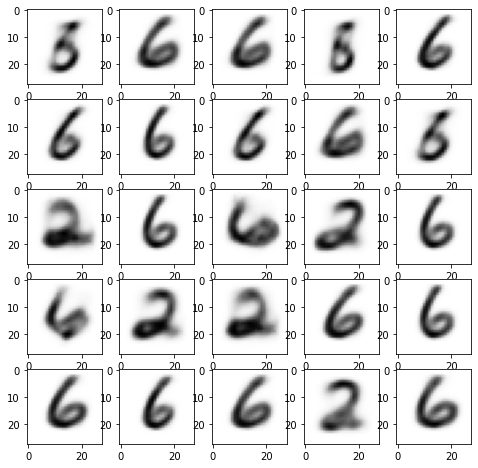

In [50]:
fig = plt.figure(figsize=(8, 8))
imgs = output.detach().numpy().squeeze()
for i in range(25):
  ax = fig.add_subplot(5, 5, 1 + i)
  plt.imshow(imgs[i], cmap='Greys')

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

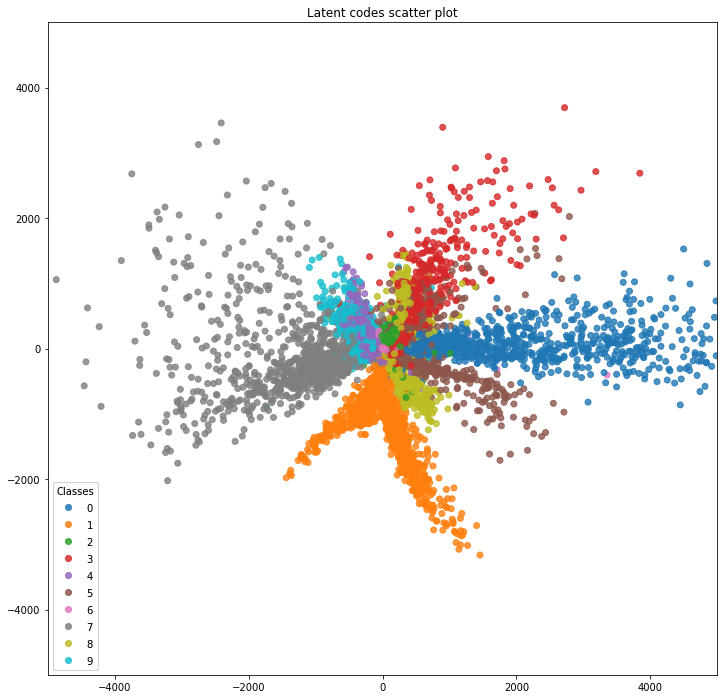

In [54]:
targets = mnist_dataset_val.targets.detach().numpy()
mus, logsigmas = vae.encode(mnist_dataset_val.data.float())
latent = vae.gaussian_sampler(mus, logsigmas).detach().numpy()

# Так как размерность скрытого просторанства изначально была равна 2,
# то использовать методы понижения размерности не имеет смысла
# Можно визуализировать сразу:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(latent[:,0], latent[:,1],
                     c=targets, 
                     alpha=0.8,
                     cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.title.set_text('Latent codes scatter plot')
ax.set_xlim(-5000, 5000)
ax.set_ylim(-5000, 5000)
plt.show()
# Видно что векторы распределены не совсем однородно:
# векторы для тех цифр, которые могут быть похожи друг на друга лежат рядом
# например 3 и 5.

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [55]:
# Определим модель Conditional VAE для датасета mnist
class mnistCVAE(nn.Module):
    def __init__(self, dim_code=2):
      super().__init__()

      self.flatten = nn.Flatten()

      self.encoder = nn.Sequential(
        nn.Linear(28*28 + 1, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.2)
      )

      self.in_mu = nn.Linear(128, dim_code)
      self.in_logsigma = nn.Linear(128, dim_code)

      self.decoder = nn.Sequential(
        nn.Linear(dim_code + 1, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.2),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.2),
        nn.Linear(256, 28*28),
        nn.Sigmoid(),
        nn.Unflatten(1, (1, 28, 28))
      )

    def encode(self, x, y):
      x = self.flatten(x)
      x = torch.cat((x, y), dim=1)
      x = self.encoder(x)
      mu = self.in_mu(x)
      logsigma = self.in_logsigma(x)
      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            esp = torch.randn(mu.size(), device=mu.device)
            z = mu + esp * torch.exp(logsigma*0.5)
            return z
        else:
            return mu
    
    def decode(self, z, y):
        z = torch.cat((z, y), dim=1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, y):
        y = y.unsqueeze(dim=1)
        mu, logsigma = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y)

        return mu, logsigma, reconstruction

In [56]:
from time import time

In [57]:
def train_epoche_cvae(model, opt, loss_fn, data_tr):
  avg_loss = 0
  model.train()
  for (X_batch, targets) in data_tr:
    # data to device
    X_batch = X_batch.to(DEVICE, dtype=torch.float)
    targets = targets.to(DEVICE, dtype=torch.float)

    # set parameter gradients to zero
    opt.zero_grad()

    # forward
    mu, logsigma, rec = model(X_batch, targets)
    loss = loss_fn(X_batch, mu, logsigma, rec) # forward-pass
              
    loss.backward()  # backward-pass
    opt.step()  # update weights 

    avg_loss += loss / len(data_tr)

  return avg_loss

def cvae_train(model, opt, loss_fn, data_tr, data_val, epochs):
  X_val, targets_val = next(iter(data_val))
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    print(f'* Epoch {epoch+1}/{epochs}')

    tic = time()
    avg_loss = train_epoche_cvae(model, opt, loss_fn, data_tr)
    toc = time()
    train_losses.append(avg_loss.detach().cpu().numpy())
    t = toc - tic

    model.eval()
    mu_val, logsigma_val, rec_val = model(
        X_val.detach().to(DEVICE, dtype=torch.float),
        targets_val.detach().to(DEVICE, dtype=torch.float))

    mu_val = mu_val.detach().cpu()
    logsigma_val = logsigma_val.detach().cpu()
    rec_val = rec_val.detach().cpu()
    targets_val = targets_val.detach().cpu()

    val_losses.append(loss_fn(X_val, mu_val, logsigma_val, rec_val))

    torch.cuda.empty_cache()

    # Visualize
    clear_output(wait=True)
    for k in range(5):
      plt.subplot(2, 5, k+1)
      plt.imshow(X_val[k].numpy().squeeze(), cmap='Greys')
      plt.title('Real: ' + str(targets_val[k].numpy()))
      plt.axis('off')

      plt.subplot(2, 5, k+6)
      plt.imshow(rec_val[k, 0].numpy(), cmap='Greys')
      plt.title('Output: ' + str(targets_val[k].numpy()))
      plt.axis('off')
    plt.suptitle('%d / %d - loss: %f, time: %f' % (epoch+1, epochs, avg_loss, t))
    plt.show()

  return train_losses, val_losses

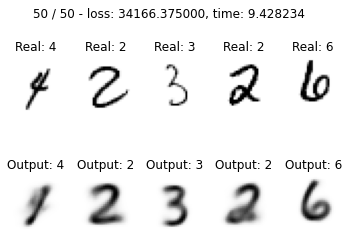

In [58]:
# Обучим сначала модель, размер скрытого пространства которой равен 2
epochs = 50
criterion = loss_fn
сvae2 = mnistCVAE().to(DEVICE)
optimizer = optim.AdamW(сvae2.parameters(), lr=1e-2)

train_losses, val_losses = cvae_train(сvae2, optimizer, criterion, data_loader_tr, data_loader_val, epochs)

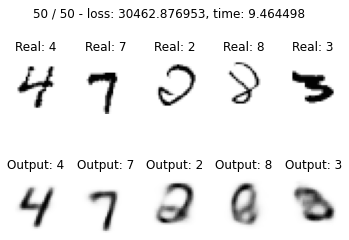

In [59]:
# А теперь размер пространства равен 4
epochs = 50
criterion = loss_fn
сvae4 = mnistCVAE(dim_code=4).to(DEVICE)
optimizer = optim.AdamW(сvae4.parameters(), lr=1e-2)

train_losses, val_losses = cvae_train(сvae4, optimizer, criterion, data_loader_tr, data_loader_val, epochs)

In [60]:
#сvae2 = mnistCVAE().to(DEVICE)
#сvae4 = mnistCVAE(dim_code=4).to(DEVICE)

cvae2_path = PATH + 'cvae2.model'
cvae4_path = PATH + 'cvae4.model'

torch.save(сvae2.state_dict(), cvae2_path)
torch.save(сvae4.state_dict(), cvae4_path)

#сvae2.load_state_dict(torch.load(cvae2_path))
#сvae4.load_state_dict(torch.load(cvae4_path))

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [62]:
# Сгенерируем цифры с определенным условием: 1 9 4 2 1
def generate_num(model, size, cond):
  z = np.random.standard_normal(size)
  z = torch.tensor(z, dtype=torch.float)
  condition = torch.tensor(cond).unsqueeze(dim=1)
  output = model.decode(z, condition)
  return output

In [63]:
сvae2 = сvae2.cpu()
output2 = generate_num(сvae2, (5, 2), (1, 9, 4, 2, 1))

In [64]:
сvae4 = сvae4.cpu()
output4 = generate_num(сvae4, (5, 4), (1, 9, 4, 2, 1))

In [65]:
output = torch.cat((output2, output4))

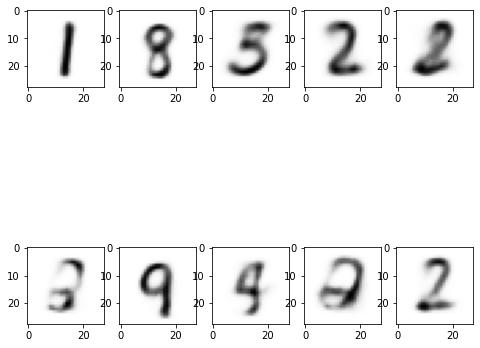

In [66]:
# И сравним получившиеся результаты для двух разных моделей
# Сверху cvae2, снизу cvae4
fig = plt.figure(figsize=(8, 8))

imgs = output.detach().numpy().squeeze()
for i in range(10):
  ax = fig.add_subplot(2, 5, 1 + i)
  plt.imshow(imgs[i], cmap='Greys')
# Видно, что результат первой модли лучше

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

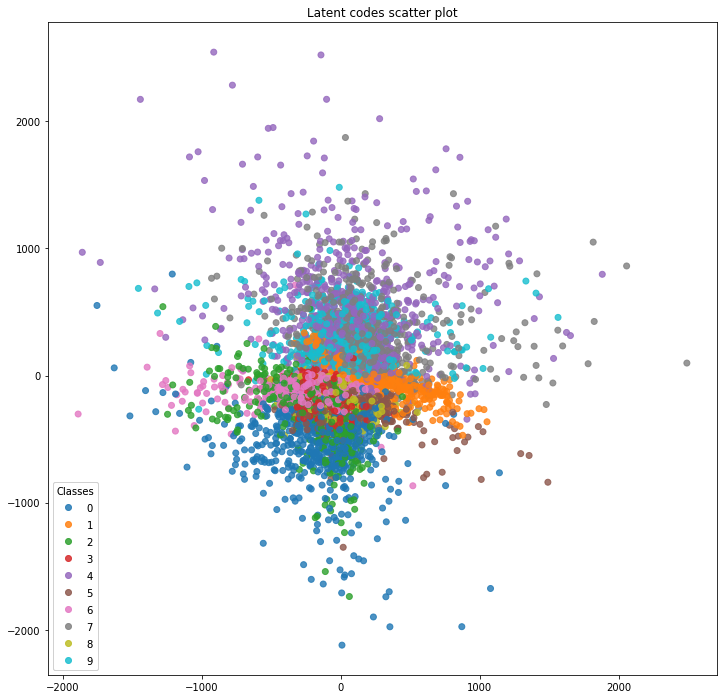

In [68]:
# Точно также посмотрим на латентное пространство наших картинок с цифрами
# Оно досточно сильно отличается от представления для vae: 
# большее пересечение и наложение кластеров
targets = mnist_dataset_val.targets
mus, logsigmas = сvae2.encode(mnist_dataset_val.data.float(), 
                             targets.unsqueeze(dim=1))
targets = targets.detach().numpy()
latent = сvae2.gaussian_sampler(mus, logsigmas).detach().numpy()

fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(latent[:,0], latent[:,1],
                     c=targets, 
                     alpha=0.8,
                     cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.title.set_text('Latent codes scatter plot')
plt.show()

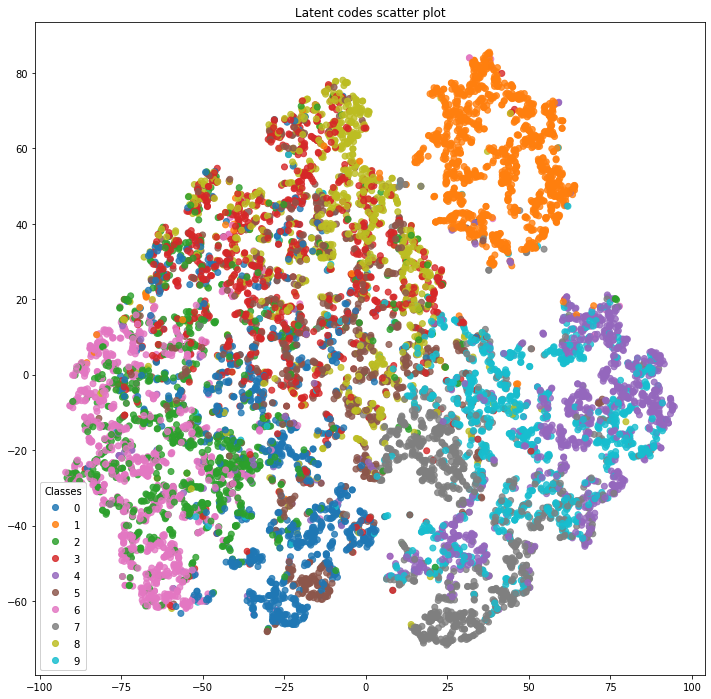

In [69]:
from sklearn.manifold import TSNE
# И для cvae4 также, предварительно уменьшив размерность пространства до 2.
# Можно увидить некоторые кластеры, которые могут пересекаться для похожих цифр

targets = mnist_dataset_val.targets
mus, logsigmas = сvae4.encode(mnist_dataset_val.data.float(), 
                             targets.unsqueeze(dim=1))
targets = targets.detach().numpy()
latent = сvae4.gaussian_sampler(mus, logsigmas).detach().numpy()
latent_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(latent)

fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(latent_embedded[:,0], latent_embedded[:,1],
                     c=targets, 
                     alpha=0.8,
                     cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.title.set_text('Latent codes scatter plot')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [134]:
# Прогоним тренеровочную часть датасета через нашу модель 
# и сохраним латентные векторы для этих изображений
cvae.eval()

with torch.no_grad():
  for num, d in enumerate(data_tr):
    batch_, p = d
    batch = batch_.to(DEVICE, dtype=torch.float)

    mu, logsigma = cvae.encode(batch)
    z = cvae.gaussian_sampler(mu, logsigma)

    if num == 0:
      codes = z
      persons = p
    else:
      codes = torch.cat((codes, z), dim=0)
      persons = np.concatenate((persons, p), axis=0)

    

In [135]:
codes = codes.detach().cpu().numpy()
persons = list(persons)

In [137]:
# обучаем NearestNeighbors
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_jobs=-1).fit(codes)

In [140]:
def get_similar(image, model, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  mu, logsigma = model.encode(image)
  code = model.gaussian_sampler(mu, logsigma)
    
  (distances,),(idx,) = neigh.kneighbors(code.detach().cpu().numpy(), n_neighbors=n_neighbors, return_distance=True)

  return distances, data[training_idx][idx,:,:,:]

In [145]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances, neighbors = get_similar(image, cvae, n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.squeeze().cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    plt.axis('off')
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
        plt.axis('off')
    plt.show()

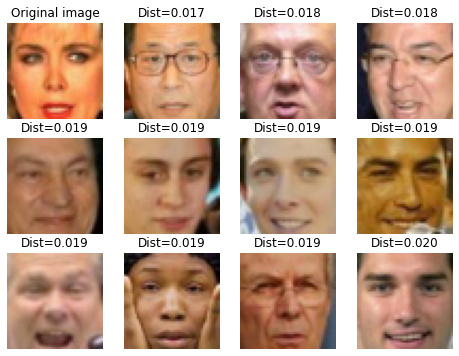

In [148]:
# Выводим случайное изображение из валидационного датасета и 11 ближайших к нему
show_similar(val_imgs[int(np.random.uniform(0,len(val_imgs)))][0] \
             .unsqueeze(0) \
             .to(DEVICE, dtype=torch.float))

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

Бот был написан на основе модели сверточного вариационного автоэнкодера. Он принемает на вход изображение лица человека из чата, сжимает его до размера 45 на 45 и получает латентный вектор данного изображения. Затем ищет ближайший скрытый вектор картинок из lfw датасета и отправляет изображение этого человека в чат.

Ссылки:

*   [Github](https://github.com/babyraggge/searchbot) 
*   [Telegram](https://t.me/vaesface_bot)

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!